<a href="https://colab.research.google.com/github/Guilli12pm/ML_proj/blob/master/project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning project

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

'1.13.1'

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

##Download the images

In [4]:
#https://github.com/Guilli12pm/ML_proj/raw/master/next_ite.tar.gz
import pathlib
data_root_orig = tf.keras.utils.get_file('next_ite',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/next_ite.tar.gz',
                                         untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

5300224/5297110 [==============================] - 0s 0us/step
/root/.keras/datasets/next_ite


##Inspect the dataset

In [5]:
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/next_ite/.DS_Store
/root/.keras/datasets/next_ite/Nicholas_S
/root/.keras/datasets/next_ite/Guillaume_Loranchet


We create a list of all pictures and shuffle

In [14]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

146

In [15]:
all_image_paths[:10]

['/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_90.png',
 '/root/.keras/datasets/next_ite/Guillaume_Loranchet/Guillaume_Loranchet_37.png',
 '/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_36.png',
 '/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_15.png',
 '/root/.keras/datasets/next_ite/Guillaume_Loranchet/Guillaume_Loranchet_39.png',
 '/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_82.png',
 '/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_68.png',
 '/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_75.png',
 '/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_86.png',
 '/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_44.png']

###Show images

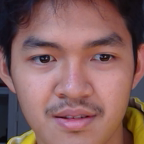

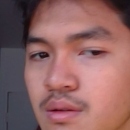

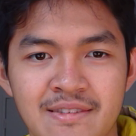

In [16]:
import IPython.display as display

for n in range(3):
  image_path = random.choice(all_image_paths)
  #print('image path: ',image_path)
  display.display(display.Image(image_path))

###Label images

In [17]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Guillaume_Loranchet', 'Nicholas_S']

In [18]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Guillaume_Loranchet': 0, 'Nicholas_S': 1}

In [19]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 0, 1, 1, 0, 1, 1, 1, 1, 1]


###Load images with Tensor Flow

In [26]:
img_path = all_image_paths[0]
img_path

'/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_90.png'

raw data

In [27]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=39, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x...


In [28]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(147, 147, 3)
<dtype: 'uint8'>


In [31]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
0.90094113


In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

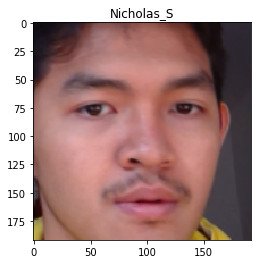

In [35]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
#plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

##Build a tf.data.Dataset